# Exercise 3: More tabular data wrangling.

Skills:
* Looping
* Dictionary to map values
* Dealing with duplicates
* Make use of Markdown cells to write some narrative or commentary!

References:
* https://docs.calitp.org/data-infra/analytics_new_analysts/02-data-analysis-intermediate.html

In [1]:
import pandas as pd

In [2]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/bus_service_increase/"
FILE_NAME = "ntd_metrics_2019.csv"

df = pd.read_csv(f"{GCS_FILE_PATH}{FILE_NAME}")
df.shape

/opt/conda/lib/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


(3685, 45)

In [3]:
# in all columns in df, relace string formats with other formats
df.columns = df.columns.str.replace('\n', ' ').str.replace(' ', '_')
df.shape

(3685, 45)

In [4]:
print(f"# obs: {len(df)}")
print(f"# unique IDs: {df.NTD_ID.nunique()}")

# obs: 3685
# unique IDs: 2183


In [5]:
# Pick an example -- see that agency provides service for different modes
# df.NTD_ID.value_counts()
df[df.NTD_ID=="10003"].Mode.value_counts()


MB    2
FB    1
DR    1
CR    1
RB    1
HR    1
TB    1
LR    1
Name: Mode, dtype: int64

### Dealing with Duplicates

* Explore why there are duplicates
* What's the analysis about? What should the unit of analysis be?
* Should duplicates be dropped? Should duplicates be aggregated into 1 entry?
* Hint: It depends on the analysis, and there might be a bit of both. Sometimes, aggregation makes sense. Duplicates require further investigation -- why do they appear in the dataset multiple times? Unless it's completely duplicate information, it doesn't make sense to just drop. It may show that the analysis can be more disaggregate than previously thought.

In [6]:
# But what about this case?
# in the df, in series call Agency, check if string contains .... AND in Agency series, filter for cells that are not empty. then do value counts of not empty rows.
# duplicates may indicate a 1:m relationship with another table. or like, in the warehouse, if something is 'current' or has a different timestamp

df[(df.Agency.str.contains("Los Angeles County Metropolitan Transportation Authority ")) 
   & (df.Agency.notna())].Mode.value_counts()

MB    2
HR    1
RB    1
LR    1
VP    1
Name: Mode, dtype: int64

In [7]:
# Find the column that has different values

#VEHICLE_REVENUE_MILES

df[(df.Agency.str.contains("Los Angeles County Metropolitan Transportation Authority ")) 
   & (df.Agency.notna()) & 
   (df.Mode=="MB")
  ]

,Agency,City,State,Legacy_NTD_ID,NTD_ID,Organization_Type,Reporter_Type,Primary_UZA__Population,Agency_VOMS,Mode,...,Passenger_Miles_Questionable,Vehicle_Revenue_Miles,Vehicle_Revenue_Miles_Questionable,Any_data_questionable?,Unnamed:_39,Unnamed:_40,Unnamed:_41,1,Unnamed:_43,Unnamed:_44
16,Los Angeles County Metropolitan Transportation...,Los Angeles,CA,9154,90154,Independent Public Agency or Authority of Tran...,Full Reporter,"12,150,996","3,469",MB,...,NaN,"65,595,822",NaN,No,NaN,NaN,NaN,NaN,NaN,NaN
17,Los Angeles County Metropolitan Transportation...,Los Angeles,CA,9154,90154,Independent Public Agency or Authority of Tran...,Full Reporter,"12,150,996","3,469",MB,...,NaN,"5,775,759",NaN,No,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
subset_cols = [
    'Agency', 'City', 'State', 'Legacy_NTD_ID', 'NTD_ID',
    'Organization_Type', 'Reporter_Type', 'Mode'
]

print(f"# obs: {len(df)}")
print(f"# obs after dropping dups: {len(df.drop_duplicates(subset=subset_cols))}")

# What does this indicate? Use Markdown cell and jot down some of the logic.

# obs: 3685
# obs after dropping dups: 3553


### Response to above
The initial dataframe has 3,685 rows. 

However, based on the columns listed in the `subset_col` list, the `df.dtop_duplicates` dataframe now only has 3,553 rows. 
Indicaating that there are some duplicate rows based on the `subset_col` list, but may have been unique rows in the initial dataframe. The rows may start to differ outside of the `subset_col` list.


[Markdown reference](https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook)

### Changing values by using a dictionary to map

In [12]:
# Transit mode uses a code, 
# Use a dictionary to map those codes to its full name
MODE_NAMES = {
    'MB': 'Bus', 
    'LR': 'Light Rail',
    'CB': 'Commuter Bus',
}

# What happens to the ones that aren't specified in MODE_NAMES?
# assigns() creates a new col to the df. in this case, assign new col called mode_full_name. then fill the col by taking the mode of the values listed in `mode_names` list.
df = df.assign(mode_full_name = df.Mode.map(MODE_NAMES))


In [10]:
#only prits the `mode_names` we defined above and leaves the rest of the undefined rows blank? So only counds the non-n/a values in the `mode_full_name` column
df.mode_full_name.value_counts()

Bus             1244
Commuter Bus     177
Light Rail        23
Name: mode_full_name, dtype: int64

In [11]:
# `isna` checks for empty values. (opposite of `notna`)
# looks at the empty values in the `mode_full_name` series in the df, and counts the values of modes in those empty values
df[df.mode_full_name.isna()].Mode.value_counts()

DR    1879
VP     112
DT     103
FB      40
CR      27
SR      22
HR      15
RB      13
YR       6
MG       6
TB       5
IP       3
TR       2
PB       1
CC       1
AR       1
Name: Mode, dtype: int64

In [15]:
# Map values from Mode to rail, bus, and other 
# used AND to consolidate some of the values. values ending with R == rail. values ending with B == Bus, the remaining is other
#last fucntions says; create dataframe called df, replacing the df from above. use assign to create a new col in df2 called 'Mode_cat'. in `mode_cat`, fill in the cells by mapping the strings in the 'mode fill' dictionary to the values in the `Mode` Col form the initial df
#also included the code form the previous directory 

mode_fill = {'AR'and'CR' and 'DR' and 'HR' and 'SR' and 'TR' and 'YR':'Rail',
             'FB' and 'PB' and 'RB'and 'TB': 'Bus',
             'CC' and 'MG' and 'IP' and 'VP' and 'DT':'other',
             'MB': 'Bus', 
             'LR': 'Light Rail',
             'CB': 'Commuter Bus',
}
df = df.assign(mode_cat = df.Mode.map(mode_fill))

# in df, count the values of each type in the `mode_cat` col
df.mode_cat.value_counts()

Bus             1249
Commuter Bus     177
other            103
Light Rail        23
Rail               6
Name: mode_cat, dtype: int64

### Looping

Can loop across columns or loop across subsets of data.

Sometimes, looping can make sense if you're repeating certain steps. Use it if it makes sense.

In [16]:
# need help unstanding this section

# for ... in ... [], this starts the Loop

# C == Agency_VOMS and Mode_VOMS
# in df[c] (aka in df Agency_VOMS and Mode_VOMS) replace the string character , with empty space, and fill in blank spaces as integer 0

for c in ["Agency_VOMS", "Mode_VOMS"]:
    df[c] = df[c].str.replace(',', '').fillna('0').astype({c: int})

In [17]:
# create a new df called subset_df based off of initial df
# within df look for 

for s in ["CA", "ID"]:
    subset_df = df[df.State==s]
    display(subset_df[["Agency", "City"]].drop_duplicates().head())

,Agency,City
13,Los Angeles County Metropolitan Transportation...,Los Angeles
72,Orange County Transportation Authority,Orange
94,Access Services,El Monte
120,"City and County of San Francisco, dba: San Fra...",San Francisco
131,San Diego Metropolitan Transit System,San Diego


,Agency,City
703,"Ada County Highway District, dba: ACHD Commute...",Boise
778,Valley Regional Transit,Meridian
1440,"City of Pocatello, dba: Pocatello Regional Tra...",Pocatello
1482,Mountain Rides Transportation Authority,Ketchum
1598,Treasure Valley Transit,Nampa


### To Do:
* Keep a subset of columns and clean up column names (no spaces, newlines, etc):
    * columns related to identifying the agency
    * population, passenger trips
    * transit mode
    * at least 3 service metric variables, normalized and not normalized
* Deal with duplicates - what is the unit for each row? What is the unit for desired analysis? Should an agency appear multiple times, and if so, why?
* Aggregate at least 2 ways and show an interesting comparison, after dealing with duplicates somehow (either aggregation and/or defining what the unit of analysis is)
* Calculate weighted average after the aggregation for the service metrics
* Decide on one type of chart to visualize, and generalize it as a function
* Make charts using the function

### Subset of columns.
column names were cleaned in previous steps

In [21]:
#identified the columns i want to keep
subset_col2 = [
   'Agency',
    'NTD_ID',
    'State',
    'Organization_Type',
    'Reporter_Type',
    'Primary_UZA__Population',
    'Agency_VOMS',
    'Mode',
    'Fare_Revenues_Earned',
    'Total_Operating_Expenses',
    'Vehicle_Revenue_Miles'
    
]

#creating a new df called df_sub that takes the initial df but only keeps the columns started in `subset_col2` (see ex 2)
df_sub = df[subset_col2]

#peaked into the df and see that the fare revenue, operating expense are `objects`, but i want `integers`
df_sub.Fare_Revenues_Earned.head()

0    $3,643,213,720 
1       $76,398,352 
2      $846,111,742 
3        $9,781,667 
4       $32,469,300 
Name: Fare_Revenues_Earned, dtype: object

In [22]:
#String Cleaning remove '$' and ',' , '()'from fare revenue and operating cost so i can change data type to int from some of the columns
#any way to concolidate this code down? maybe assign?
df_sub['Fare_Revenues_Earned'] = df_sub.Fare_Revenues_Earned.str.replace('$','').str.replace(',','').str.replace('(','').str.replace(')','')
df_sub['Total_Operating_Expenses'] = df_sub.Total_Operating_Expenses.str.replace('$','').str.replace(',','').str.replace('(','').str.replace(')','')
df_sub.head()

/tmp/ipykernel_339/1609774437.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sub['Fare_Revenues_Earned'] = df_sub.Fare_Revenues_Earned.str.replace('$','').str.replace(',','').str.replace('(','').str.replace(')','')
/tmp/ipykernel_339/1609774437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['Fare_Revenues_Earned'] = df_sub.Fare_Revenues_Earned.str.replace('$','').str.replace(',','').str.replace('(','').str.replace(')','')
/tmp/ipykernel_339/1609774437.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single ch

,Agency,NTD_ID,State,Organization_Type,Reporter_Type,Primary_UZA__Population,Agency_VOMS,Mode,Fare_Revenues_Earned,Total_Operating_Expenses,Vehicle_Revenue_Miles
0,MTA New York City Transit,20008,NY,"Subsidiary Unit of a Transit Agency, Reporting...",Full Reporter,"18,351,295",10885,HR,3643213720,5206727193,"354,616,371"
1,MTA New York City Transit,20008,NY,"Subsidiary Unit of a Transit Agency, Reporting...",Full Reporter,"18,351,295",10885,CB,76398352,242520835,"9,866,807"
2,MTA New York City Transit,20008,NY,"Subsidiary Unit of a Transit Agency, Reporting...",Full Reporter,"18,351,295",10885,MB,846111742,2685918268,"86,233,591"
3,MTA New York City Transit,20008,NY,"Subsidiary Unit of a Transit Agency, Reporting...",Full Reporter,"18,351,295",10885,DR,9781667,516470491,"37,759,280"
4,MTA New York City Transit,20008,NY,"Subsidiary Unit of a Transit Agency, Reporting...",Full Reporter,"18,351,295",10885,RB,32469300,103071355,"3,382,426"


In [24]:
#attempt to change data type for fare rev from object to int
#having trouble with the `NaN` cells

df_sub.Fare_Revenues_Earned = df_sub.Fare_Revenues_Earned.astype('Int64')
df_sub.Total_Operating_Expenses = df_sub.Total_Operating_Expenses.astype('Int64')

/tmp/ipykernel_339/3615460920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.Fare_Revenues_Earned = df_sub.Fare_Revenues_Earned.astype('Int64')
/tmp/ipykernel_339/3615460920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.Total_Operating_Expenses = df_sub.Total_Operating_Expenses.astype('Int64')


### Dealing with Duplicates

In [29]:
#Deal with duplicates - what is the unit for each row? What is the unit for desired analysis? Should an agency appear multiple times, and if so, why?
print(df_sub.shape)
print(df_sub.drop_duplicates(subset=['NTD_ID']).shape)

(3685, 11)
(2184, 11)


### Thoughts
In comparing the `df_sub` dataframe to the `df_sub.drop_duplicates...` dataframe, there is a difference in the number of rows. I dropped duplicates based on the `NTD_ID` of each row and was returned with a list of unique NTD Agencies. 

However, the reason there were duplicates in the initial dataframe was do to the categorical nature of the `Mode` col. some Agencies have different Modes of transportation, and each mode has its own distinct revenue, operating expenses and vehicle revenue miles.

Personally I would like to keep df_sub with the duplicates, and consolidate the duplicate agencies using aggregation

### Aggregations

In [49]:
#what is the total revenue earned per state
total_state_rev = df_sub.groupby('State').Fare_Revenues_Earned.agg([sum,max,min]).reset_index().sort_values('sum',ascending=False).head()
total_state_rev

,State,sum,max,min
36,NY,6646861142,3643213720,0
5,CA,1794038102,469865645,0
33,NJ,1450502578,566604397,0
16,IL,1026181987,365935097,0
21,MA,754986741,238575681,0


In [72]:
#What is the total revenue earned per agency
#also used reset index, sort values by descending, show first 5 row
df_sub.groupby('Agency').Fare_Revenues_Earned.agg([sum,max,min]).reset_index().sort_values('sum',ascending=False).head()

,Agency,sum,max,min
1286,MTA New York City Transit,4607974781,3643213720,9781667
1468,New Jersey Transit Corporation,979873625,566604397,1640036
1285,MTA Long Island Rail Road,768917681,768917681,768917681
1342,"Metro-North Commuter Railroad Company, dba: MT...",757532731,756678075,236470
1325,Massachusetts Bay Transportation Authority,671521399,238575681,85258


In [47]:
#Total operating expenses by agency
df_sub.groupby('Agency').Total_Operating_Expenses.agg([sum,max,min]).reset_index().sort_values('sum',ascending=False).head()

,Agency,sum,max,min
1286,MTA New York City Transit,8754708142,5206727193,103071355
1468,New Jersey Transit Corporation,2265083531,1024848749,9265043
2088,Washington Metropolitan Area Transit Authority,2019352824,1112675403,10081260
1260,Los Angeles County Metropolitan Transportation...,1918638766,1209706503,15376446
1285,MTA Long Island Rail Road,1507026548,1507026548,1507026548


### Weighted Average

In [64]:
# of the top 5 staes. found the percentage of each state revenue from total revnue. used those percentages as weights.
# hard coded the weights. probably a way to make like a calculated column.

total_state_rev['weights'] = [0.57, 0.15, 0.12, 0.09, 0.06]
total_state_rev

,State,sum,max,min,weights
36,NY,6646861142,3643213720,0,0.57
5,CA,1794038102,469865645,0,0.15
33,NJ,1450502578,566604397,0,0.12
16,IL,1026181987,365935097,0,0.09
21,MA,754986741,238575681,0,0.06


In [63]:
#Weighted avereage of total revenue from top 5 state
#explained. multipled each states revenue, by their weight, then summed them up. 
#then divided the revenue total by the sum of all the weights.

wt_avg = (total_state_rev['sum']*total_state_rev['weights']).sum() / total_state_rev['weights'].sum()
wt_avg

4413669150.39394

### Bar Chart

<AxesSubplot:xlabel='State'>

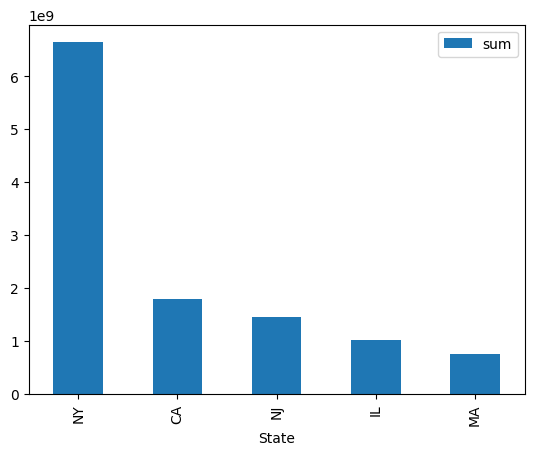

In [66]:
total_state_rev.plot.bar(x='State',y='sum')

### Chart with Altair

In [71]:
## need to look into this more

import altair as alt

def make_bar_chart(df, x_col, y_col):
    x_title = f"{x_col.title()}"
    
    chart = (alt.Chart(total_state_rev)
             .mark_bar()
             .encode(
                 x=alt.X(x_col, title=x_title),
                 y=alt.Y(y_col, title=""),
             )
            )
    return chart

chart.show()

NameError: name 'chart' is not defined

### Helpful Hints for Functions
* Opportunities are from components that are generalizable in making a chart
* Maybe these components need the same lines of code to clean them
* You can always further define variables within a function
* You can always use f-strings within functions to make slight modifications to the parameters you pass

In [ ]:
# Sample function
import altair as alt

def make_bar_chart(df, x_col, y_col):
    x_title = f"{x_col.title()}"
    
    chart = (alt.Chart(df)
             .mark_bar()
             .encode(
                 x=alt.X(x_col, title=x_title),
                 y=alt.Y(y_col, title=""),
             )
            )
    return chart


When removing files:
* `git rm folder/file.ipynb` if the file is in GitHub (checked in in the past)
* if it's not, you can use `rm folder/file.ipynb`
* if it's a folder that's been checked in, you can use `git rm folder/ -rf`, followed by `rm folder/ -rf`. r = recursive, f = force.